# 04-03 - Heuristic Likelihood Maximization

*May 15 2024*  

In real community detection tasks we cannot exhaustively calculate the maximum likelihood for all possible block assignment vectors. The number of possible vectors grows exponentially with the number of nodes, where the number of communities gives the base of the exponential growth. However, we can use "heuristic" optimization techniques to find solutions that are approximately optimal. Starting from a naive greedy maximization, in this notebook we implement *simulated annealing* a simple yet powerful heuristic optimization algorithm that is often used for combinatorial optimization tasks.

In [2]:
import pathpyG as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

plt.style.use('default')
sns.set_style("whitegrid")

from numpy import linalg as npl
import scipy as sp

import scipy.special
from decimal import *
import string
from collections import Counter
from collections import defaultdict

In the following, we will use the `pathpyG` implementation of the stochastic block model, which you can find in 

`pp.algorithms.generative_models.stochastic_block_model`

We can use this to generate a synthetic network with known ground truth communities.

In [3]:
M = np.matrix('0.95 0.05; 0.05 0.95')
z = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
n = pp.algorithms.generative_models.stochastic_block_model(M, z, pp.IndexMap(list('abcdefghij')))

colors = {0: 'red', 1: 'blue'}
pp.plot(n, node_color = [colors[z[n.mapping.to_idx(v)]] for v in n.nodes], node_label = [v for v in n.mapping.node_ids]);

We reuse the function to calculate the likelihood of a block assignment vector, which is based on the maximum-likelihood estimate of stochastic block matrix entries:

In [4]:
def log(x):
    if x == 0:
        return 0.0
    else:
        return np.log(x)

def SBM_max_likelihood(z, graph: pp.Graph):
    B = len(set(z))

    # C[k] counts number of nodes in block k
    C = Counter(z)

    L = 0
    
    # E[k,l] counts how many links exist between nodes in block k and block l
    E = np.zeros((B,B))

    # N[k,l] counts how many links can possibly exist between nodes in block k and l
    N = np.zeros((B,B))
    
    for k in range(B):
        for l in range(B):
            # calculate possible links
            if k == l:
                N[k,l] = scipy.special.binom(C[k], 2)
            else:
                N[k,l]= C[k] * C[l]
            for v,w in graph.edges:
                v_idx = graph.mapping.to_idx(v)
                w_idx = graph.mapping.to_idx(w)
                if v_idx < w_idx and ((z[v_idx] == k and z[w_idx] == l) or (z[v_idx] == l and z[w_idx] == k)):
                    E[k,l] += 1
    M = E / N
    for k in range(B):
        for l in range(k+1):
            L+= E[k,l] * log(M[k,l]) + (N[k,l] - E[k,l]) * log(1-M[k,l])

    return L, M

In the previous notebook, we exhaustively enumerated all possible block assignment vectors for a given number of communities $B$. Let us first try a naive greedy search algorithm to find the parameters that maximize the model likelihood. We initially assign each node to a different community (i.e. starting with $B=n$ blocks). For a number of iterations, we then repeatedly merge a random pair of communities and recompute the likelihood. If the change increases the likelihood, we accept it, otherwise, we reject it and try again.

In [5]:
def naive_greedy(graph: pp.Graph, B, iterations=1000):
    likelihoods = []
    n = graph.N
    z = np.zeros(n, dtype=int)
    for i in range(n):
        z[i] = int(np.random.randint(B))
    l, m = SBM_max_likelihood(z, graph)
    l = np.exp(l)

    for i in tqdm(range(iterations)):

        # randomly change community of random node
        z_new = z.copy()
        z_new[np.random.randint(n)] = int(np.random.randint(B))

        # check whether likelihood increases
        l_new, _ = SBM_max_likelihood(z_new, graph)
        l_new = np.exp(l_new)
        if l_new > l:
            z = z_new
            l = l_new
        likelihoods.append(l)
    return z, likelihoods

We try this in our example network, which exhibits a clear community structure.

In [6]:
z_detected, likelihoods = naive_greedy(n, B=2, iterations=1000)
print(z_detected)
print(likelihoods)

colors = {0: 'red', 1: 'blue'}
pp.plot(n, node_color = [colors[z_detected[n.mapping.to_idx(v)]] for v in n.nodes], node_label = [v for v in n.mapping.node_ids]);

/tmp/ipykernel_144/541435914.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/1000 [00:00<?, ?it/s]

[0 0 0 0 0 1 1 1 1 1]
[1.822631423425916e-13, 1.822631423425916e-13, 1.822631423425916e-13, 1.822631423425916e-13, 1.822631423425916e-13, 8.307900354415944e-10, 8.307900354415944e-10, 8.307900354415944e-10, 8.307900354415944e-10, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.2539005741266677e-05, 2.

In [7]:
max_l, M = SBM_max_likelihood(z, n)
print(np.exp(max_l))

2.2539005741266677e-05


Unfortunately, this simple approach fails even for our small example network! While you may suspect that we simply did not use a large enough number of iterations, the real problem is that this naive greedy search strategy gets quickly stuck in a *local maximum*, where any change in the community structure would decrease the likelihood. This prevents the algorithm from finding the *global* maximum. We can confirm this if we plot the evolution of the likelihood, which shows that the algorithm gets stuck quickly in, what we know to be, a local maximum. The likelihood of the ground truth communities is indicated by the red horizontal line.

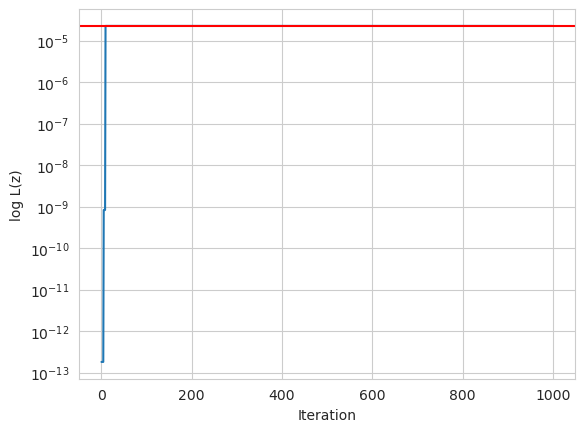

In [8]:
plt.plot(range(1000), likelihoods)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('log L(z)')
plt.axhline(y=np.exp(max_l), color='red')


This plot confirms that the greedy algorithm gets stuck in a local maximum from which it cannot escape, because any change of a block label (temporarily) decreases the likelihood. This is a common problem with naive greedy optimization in complex solution landscapes that have local optima. An elegant way to address this is by applying simulated annealing. This term is borrowed from the annealing of metal, where we repeated heat metal to allow the atomic structure to reorganize in an optimal crystal structure. High temperatures in the heating process introduce random fluctuations which enable to escape local energy optima of the atomic structure.

In [9]:
def simulated_annealing(network: pp.Graph, B, cooling_slowness = 100, changes_per_iter=1, iterations=1000):
    likelihoods = []
    n = network.N
    z = np.zeros(n, dtype=int)
    for i in range(n):
        z[i] = int(np.random.randint(B))
    l, m = SBM_max_likelihood(z, network)
    l = l

    # we output the cooling temperatures to inspect the cooling schedule
    temperatures = []

    for i in tqdm(range(iterations)):

        t = (1+cooling_slowness)/(i+1+cooling_slowness)

        # randomly change community of random node
        z_new = z.copy()
        z_new[np.random.randint(n)] = int(np.random.randint(B))

        for i in range(changes_per_iter):
            i = np.random.choice(n)
            z_new[i] = np.random.choice(B)
        l_new, m_new = SBM_max_likelihood(z_new, network)
        if l_new >= l or np.random.random() <= np.exp(-(l-l_new)/t):
            z = z_new
            l = l_new

        likelihoods.append(np.exp(l))
        temperatures.append(t)
    return z, likelihoods, temperatures

In [10]:
z_detected, likelihoods, temperatures = simulated_annealing(n, B=2, changes_per_iter=1, iterations=200)
print(z_detected)
print(likelihoods)

colors = {0: 'red', 1: 'blue'}
pp.plot(n, node_color = [colors[z_detected[n.mapping.to_idx(v)]] for v in n.nodes], node_label = [v for v in n.mapping.node_ids]);

/tmp/ipykernel_144/2819241426.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/200 [00:00<?, ?it/s]

[0 0 0 0 0 1 1 1 1 1]
[8.074875362669755e-14, 9.335846324194167e-14, 5.178463546417251e-14, 5.769689513828722e-14, 5.178463546417251e-14, 5.769689513828722e-14, 8.074875362669755e-14, 7.224611157840118e-14, 7.75107442669604e-14, 1.3692827128237032e-13, 1.3692827128237032e-13, 7.75107442669604e-14, 5.750639988671206e-14, 5.750639988671206e-14, 5.750639988671206e-14, 1.606939631954127e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 5.204584816227248e-13, 1.606939631954127e-13, 1.606939631954127e-13, 1.606939631954127e-13, 1.7075976405545754e-12, 1.7075976405545754e-12, 1.7075976405545754e-12, 1.7075976405545754e-12, 1.7075976405545754e-12, 1.2816290993762469e-11, 1.2816290993762469e-11, 1.2816290993762469e-11, 1.2816290993762469e-11, 1.2816290993762469e-11, 1

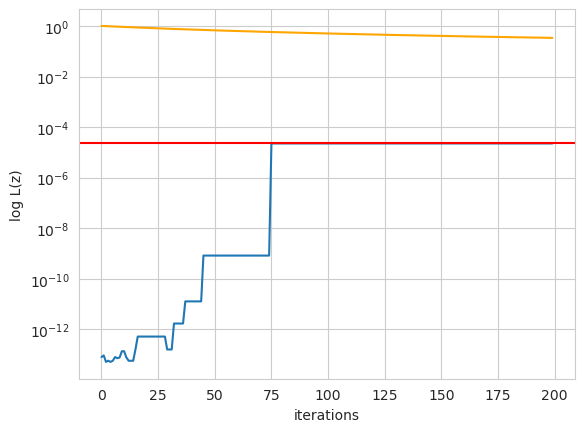

In [11]:
plt.plot(range(200), likelihoods)
plt.plot(range(200), temperatures, color='orange')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('log L(z)')
plt.axhline(y=np.exp(max_l), color='red')

## Evaluating community detection

We now introduce measures to evaluate the quality of community structures detected in networks, where we have ground truth. This helps us to quantitatively assess community detection algorithms, e.g. in networks generated using generative models such as the stochastic block mode. 

A common approach to assess the quality of detected clusters uses Normalized Mutual Information, a statistical measure that captures the mutual dependence between two random variables. It is the normalized version of mutual information, which captures the amount of information (e.g. in bits) that we obtain about the value of one random variable if we know the value of the other. The maximum value of mutual information depends on the entropy of the random variables, which is why we the normalized  variant divides the mutual information by the sum of entropies of the two random variables. 

The normalized mutual information assumes values in $\left[0, 1 \right]$, where a value of $1$ indicates that the two random variables are perfectly dependent on each other.

In the following, we implement this measure and test it in a simple example:

In [13]:
def log2(x):
    if x != 0:
        return np.log2(x)
    else:
        return 0

def P(z):
    c = Counter(z)
    total = sum(c.values(), 0.0)
    for key in c:
        c[key] /= total
    return c

def JointProb(z1, z2):
    p = Counter()
    for i in range(len(z1)):
        p[(int(z1[i]), int(z2[i]))] += 1
    total = sum(p.values(), 0.0)
    for key in p:
        p[key] /= total
    return p

def H(p):   
    h = 0
    for i in p:
        h -= p[i] * log2(p[i])
    return h

def MI(z1, z2):
    max_val = max(max(z1), max(z2))
    
    # marginal prob. dist. 
    marginal1 = P(z1)
    marginal2 = P(z2)
    
    # joint prob. dist 
    joint = JointProb(z1, z2)

    mi = 0
    for x in range(max_val+1):
        for y in range(max_val+1):
            mi += joint[(x,y)] * log2(joint[(x,y)]/(marginal1[x]*marginal2[y]))
    return mi


def NMI(z1, z2):
    # compute entropies
    h1 = H(P(z1))
    h2 = H(P(z1))
    # compute MI
    mi = MI(z1, z2)
    return 2 * mi/(h1 + h2) 

We first consider the entropy of a binary cluster assignment of four nodes, where two nodes are assigned to each cluster. The probability of a node to be assigned to each cluster is $\frac{1}{2}$ and thus we obtain an entropy of 1 bit. We will learn more about entropy, and its use in community detection and compression in the next lecture.

In [14]:
H(P([0, 0, 1, 1]))

1.0

The entropy increases if we assign one node to a third cluster.

In [15]:
H(P([0, 0, 1, 2]))

1.5

If, on the other hand, we were to assign three of the four nodes to one cluster, the entropy decreases:

In [16]:
H(P([0, 1, 1, 1]))

0.8112781244591328

We compute the mutual information between two cluster assignments. In our first example, there is no "correlation" between the two cluster assignments, i.e. we could say that they are actually orthogonal. Here, knowing the cluster of a node in one assignment does not tell us anything about the cluster of that node in the other assignment. Consequently, mutual information is zero:

In [17]:
MI([0,0,1,1], [0,1,0,1])

0.0

The mutual information increases if we introduce a "correlation", e.g. we only change the cluster assignment for one of the nodes:

In [18]:
MI([0,0,1,1], [0,0,0,1])

0.31127812445913283

If we make thr two cluster assignments identical, we obtain a maximum value of one bit.

In [19]:
MI([0,0,1,1], [0,0,1,1])

1.0

Note that mutual information is insensitive of the actual cluster labels that we assign. It only depends on whether the same groups of nodes are assigned the same labels, irrespective of what that label is. This makes it very useful to evaluate the output of community detection algorithms.

In [20]:
MI([0,0,1,1], [1,1,0,0])

1.0

The fact that we reach a maximum value of one is due to the fact that we considered (i) a binary clustering and (ii) we have the same number of nodes in both clusters. The maximum mutual information can be larger than one if the entropy of the underlying variables is larger than one bit. This is the case in the following example of a community assignment with three communities.

In [21]:
MI([1,1,0,2], [0,0,2,1])

1.5

Similarly, the maximum mutual information that we can reach for perfectly corresponding community assignments can be smaller than one if the entropy is smaller than one bit:

In [22]:
MI([1,1,1,0], [0,0,0,1])

0.8112781244591328

This can be addressed based on the normalized mutual information, which - due to the normalization with the entropy of both assignments - assumes a value of one in both cases:

In [23]:
NMI([1,1,1,0], [0,0,0,1])

1.0

In [24]:
NMI([1,1,0,2], [0,0,2,1])

1.0

We can use normalized mutual information (NMI) to evaluate the output of community detection with the stochastic block model. We first create a synthetic network:

In [25]:
M = np.matrix('0.95 0.07; 0.07 0.95')
z_ground_truth = np.array([0, 0, 0, 1, 1, 1, 1])
n = pp.algorithms.generative_models.stochastic_block_model(M, z_ground_truth, pp.IndexMap(list('abcdefg')))

colors = {0: 'red', 1: 'blue'}
pp.plot(n, node_color = [colors[z_ground_truth[n.mapping.to_idx(v)]] for v in n.nodes], node_label = [v for v in n.mapping.node_ids]);

The block assignment vector `z_ground_truth` contains the **ground truth community labels** that we used to generate the network. We can now use the stochastic block model to infer community structures based on the generated topology. We use the simulated annealing algorithm from above:

In [26]:
z_detected, likelihoods, temperatures = simulated_annealing(n, B=2, changes_per_iter=1, iterations=200)

colors = {0: 'red', 1: 'blue'}
pp.plot(n, node_color = [colors[z_detected[n.mapping.to_idx(v)]] for v in n.nodes], node_label = [v for v in n.mapping.node_ids]);

/tmp/ipykernel_144/2819241426.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_144/1173683066.py:33: RuntimeWarning: invalid value encountered in divide
  M = E / N


We can now evaluate the quality of detected communities. Due to numerical precision, we may get values smaller than one even for a perfect assignment.

In [27]:
NMI(z_detected, z_ground_truth)

0.9999999999999999

## Application to an empirical network

We finally apply community inference with the stochastic block model to an empirical network. We again use the Karate club network considered in the first notebook.

In [28]:
n = pp.io.read_netzschleuder_network('karate', '77')

We plot the network with its ground truth community labels.

In [29]:
colors = {1: 'red', 2: 'blue'}
pp.plot(n, node_color = [colors[n['node_groups', v][0]] for v in n.nodes]);

We then use the same code as in the first notebook to generate a ground truth block assignment vector.

In [30]:
ground_truth = [n['node_groups', v][0]-1 for v in n.nodes]
print(ground_truth)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


We now use the simulated annealing algorithm to find community structures that maximize the likelihood of the stochastic block model.

In [31]:
z,l,t = simulated_annealing(n, B=2)

/tmp/ipykernel_144/2819241426.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Let us visualize our solution:

In [32]:
colors = {0: 'red', 1: 'blue'}
pp.plot(n, node_color = [colors[z[n.mapping.to_idx(v)]] for v in n.nodes]);

The result is surprisingly bad, which is confirmed by the close to zero NMI score.

In [33]:
NMI(ground_truth, z)

0.005003706234155969

Let us investigate what is the problem. We first check (i) whether we simply used a number of iterations that was too small, and (ii) whether the likelihood of the detected communities is smaller than the likelihood of our ground truth community labels.

In [34]:
max_l, _ = SBM_max_likelihood(ground_truth, n)

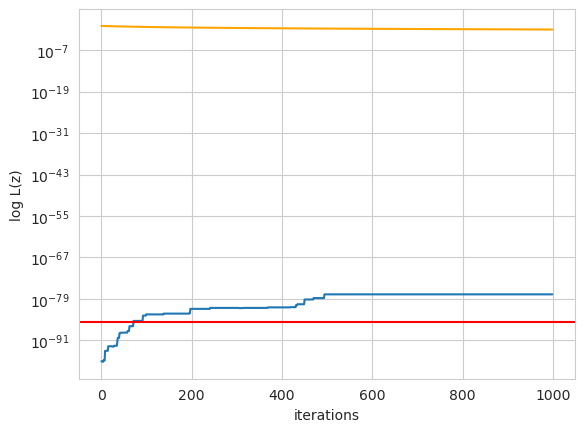

In [35]:
plt.plot(range(1000), l)
plt.plot(range(1000), t, color='orange')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('log L(z)')
plt.axhline(y=np.exp(max_l), color='red')

The likelihood of the ground truth block assignment vector is given by the red horizontal line. We see that we reached a stable solution, i.e. increasing the number of iterations will not help us. To our surprise, we find that the simulated annealing algorithm actually found a solution that has higher likelihood than the ground truth. This highlights an issue with the stochastic block model that we will address in the final section of today's lecture.